## XGBOOST Implementation

In [35]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from numpy import std
from numpy import mean
import numpy as np
import os
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

### Select which model to run
#### (only run one of the following two cells)

In [36]:
measured_side = 'right'

In [41]:
measured_side = 'left'

In [42]:
# Default Speed is Normal
# Speed = s - SLOW
#       = n - NORMAL
#       = f - FAST

measured_side_short = measured_side[0:1]

Speed = "n"
measured_side_short

print('Running datasets and predictions for ' + measured_side + ' foot at speed=' + Speed)

Running datasets and predictions for left foot at speed=n


# IMPORT DATA

### Import Moticon Interpolated Data

In [43]:
moticon_HC = pd.read_csv('data/Moticon/digital_insole_HC_vGRF_' + measured_side_short.lower() + '_' +  Speed.lower() + '.csv').drop(columns=['speed'])
moticon_HC['CLASS_LABEL'] = 0

moticon_OA = pd.read_csv('data/Moticon/digital_insole_OA_vGRF_' + measured_side_short.lower() + '.csv')
moticon_OA['CLASS_LABEL'] = 1

moticon = pd.concat([moticon_HC, moticon_OA], ignore_index = True)

moticon_remain = moticon[['ID', 'Injury', 'IDXKNEE', 'CLASS_LABEL']]

#print some stats about the dataset
print("Total Healthy Control Observations (walks):", len(moticon_HC))
print("Number of Unique Healthy Control Subjects:", len(set(moticon_HC['ID'])))
print("Total Osteo-Arthritis Clinical Observations (walks):", len(moticon_OA))
print("Number of Unique Osteo-Arthritis Clinical Subjects:",len(set(moticon_OA['ID'])))

len(moticon), set(moticon['CLASS_LABEL'])


Total Healthy Control Observations (walks): 21
Number of Unique Healthy Control Subjects: 21
Total Osteo-Arthritis Clinical Observations (walks): 35
Number of Unique Osteo-Arthritis Clinical Subjects: 35


(56, {0, 1})

### normalize using column-wise z-score

In [44]:
moticon_nolabel = moticon.drop(columns=['ID', 'Injury', 'IDXKNEE', 'CLASS_LABEL'])
moticon_nolabel = np.array(moticon_nolabel, dtype=np.float64)

moticon_mean = np.mean(moticon_nolabel, axis=0)
moticon_std = np.std(moticon_nolabel, axis=0)

X_moticon_norm = (moticon_nolabel - moticon_mean)/moticon_std
X_moticon_norm = pd.DataFrame(X_moticon_norm)
X_moticon_norm = pd.concat((X_moticon_norm, moticon_remain['ID'].reset_index().drop(columns=['index'])),axis=1)
X_moticon_norm = X_moticon_norm.set_index('ID')


### Testing Model on Moticon Data

In [45]:

#################################################################
#STEP 2: Start modeling with leave-subject-out approach
subject_classification_results = {} #stores metrics for each left-out subject
y_prob = [] #store all predictions
y_pred = [] #store all predictions
y_target = [] #store all target labels
allsub = np.unique(X_moticon_norm.index) #np.unique() because we want to leave out the entire subject, not just the individual walks
for left_out in allsub: #each for loop leaves a different subject out and creates a new model
    data_all_copy = copy.deepcopy(X_moticon_norm)
#################################################################
#STEP 2.1: Create test/train x and y data
#    print("Leaving out subject:", left_out)#don't change data_all
    X_train = data_all_copy.drop(left_out)
    ytmp = []
    for walk in X_train.index:
        if "HC" in walk: 
            ytmp.append(0)
        else:
            ytmp.append(1)
    y_train = np.array(ytmp)
    
    left_out_index = data_all_copy.index == left_out
    X_test = data_all_copy.iloc[left_out_index,:]
    ytmp = []

    if "HC" in left_out: 
        y_test = 0
    else:
        y_test = 1
        
#################################################################
#STEP 2.2: Scale the data, fit to model, and predict on test set
    metrics = {} #holds any metrics you want for the left-out subject. resets for each new subject
        
    model = XGBClassifier(eval_metric='mlogloss' )

    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
         
    # calculate metrics
    acc = accuracy_score([y_test], yhat)
    
    # Save predictions
    y_pred.extend(yhat)
    y_prob.extend([x[1] for x in model.predict_proba(X_test)])
    y_target.extend([y_test])
    metrics["Accuracy"] = acc #note that you can add any metrics on top of accuracy to the 'metrics' dict to save for later

    subject_classification_results[left_out] = metrics #save results for left-out subject
#    print("Classification for Subject " + left_out + ": " + str(acc))
  
#################################################################
#STEP 3: Show the accuracy results
val = []
for idx, k in enumerate(subject_classification_results.keys()):
    val.append(subject_classification_results[k]['Accuracy'])
print(measured_side + ' - ' + Speed )
print(classification_report(y_target, y_pred))


moticon_fpr, moticon_tpr, thresholds = roc_curve(y_target, y_prob)
print('\033[1mauROC score: {0:.4f}'.format(roc_auc_score(y_target, y_prob)))
moticon_precision, moticon_recall, thresholds = precision_recall_curve(y_target, y_prob)
print('\033[1mauPR score: {0:.4f}'.format(auc(moticon_recall, moticon_precision)))


left - n
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.91      0.91      0.91        35

    accuracy                           0.89        56
   macro avg       0.89      0.89      0.89        56
weighted avg       0.89      0.89      0.89        56

auROC score: 0.9673
auPR score: 0.9794


## Plot Results

In [46]:
from plotnine import ggplot, geom_line, scale_color_manual, theme_bw, geom_abline, xlab, geom_hline, aes, ylim


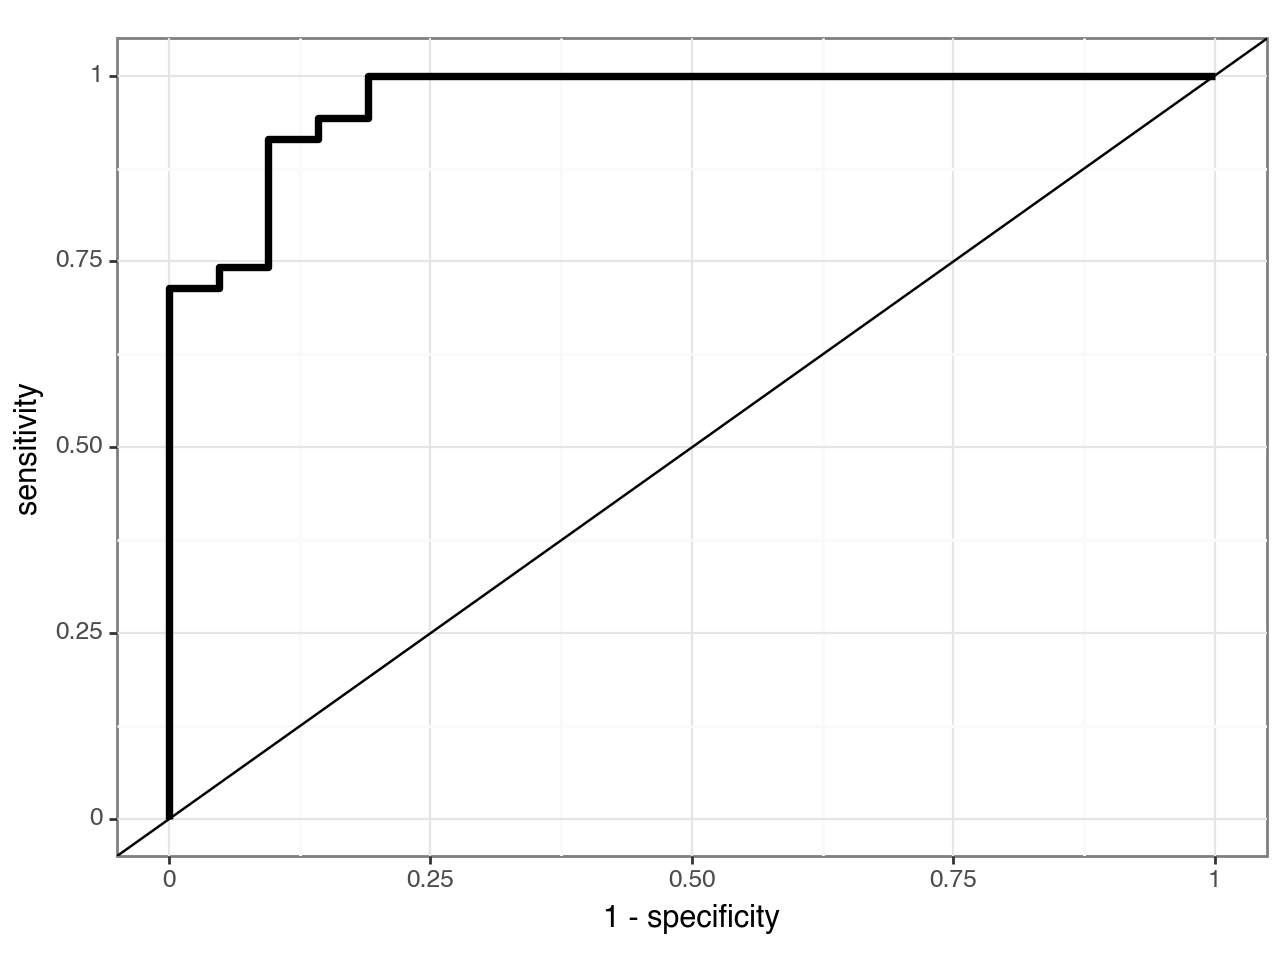

In [48]:
roc_data = pd.concat([
    pd.DataFrame({'fpr' : moticon_fpr, 'sensitivity' : moticon_tpr, 'dataset' : 'Wearable Digital Insole\nTest Set'})
])

print(
    ggplot(roc_data, aes(x = "fpr", y= "sensitivity"))
    + geom_line(size = 1.5)
    + theme_bw()
    + geom_abline(intercept = 0, slope = 1)
    + xlab('1 - specificity')
)


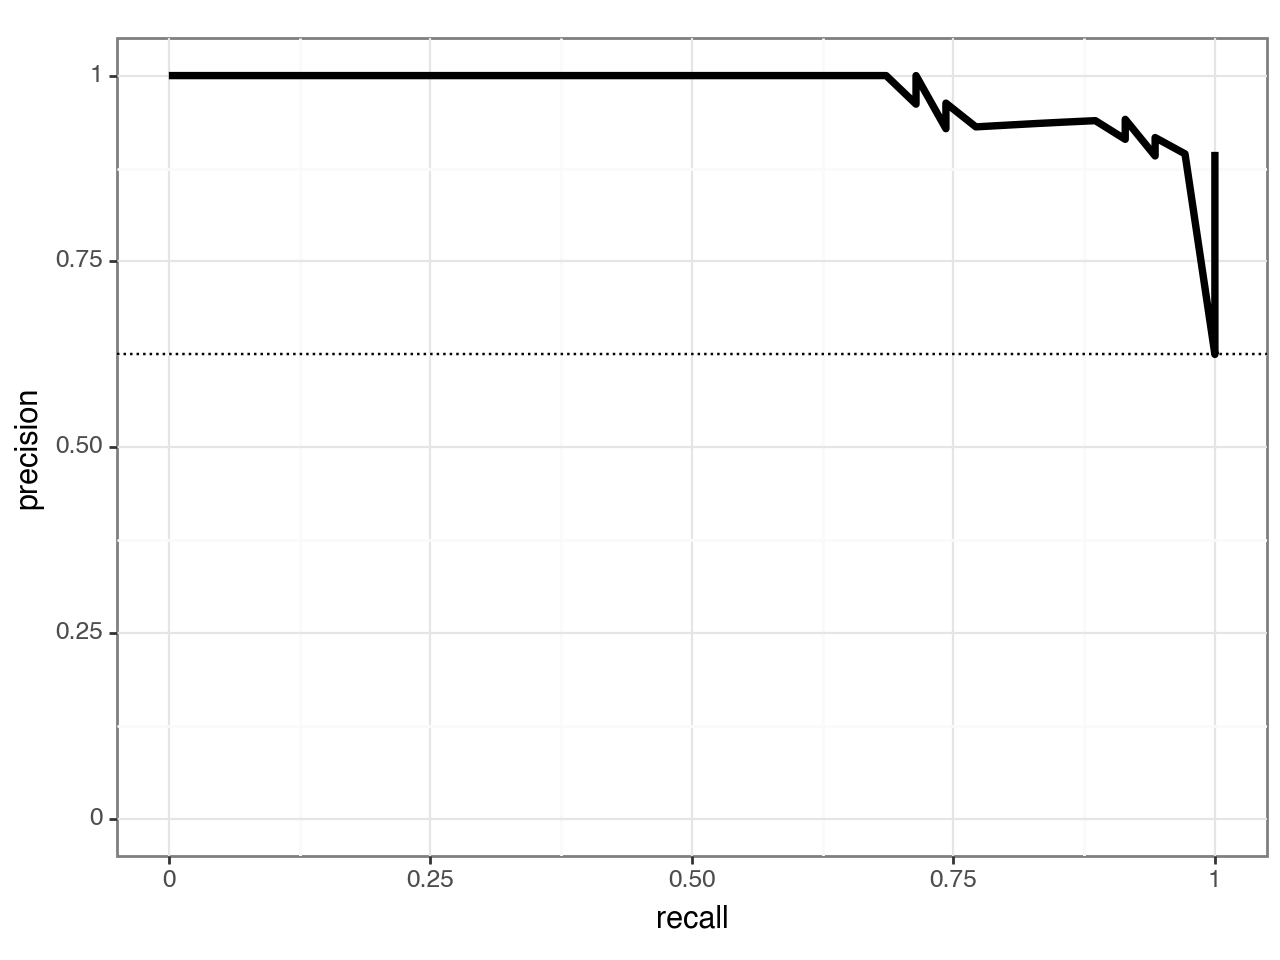

In [51]:
pr_data = pd.concat([
    pd.DataFrame({'precision' : moticon_precision, 'recall' : moticon_recall, 'dataset' : 'Wearable Digital Insole\nTest Set'})
])

print(
    ggplot(pr_data, aes(x = "recall", y= "precision"))
    + geom_line(size = 1.5)
    + theme_bw()
    + ylim(0,1)
    + geom_hline(yintercept =  sum(y_target) / len(y_target), linetype = "dotted")
)
